# Individual glacier surface velocity analysis

This notebook will build upon the data access and inspection steps in the earlier notebooks and demonstrate basic data analysis and visualization of surface velocity data at the scale of an individual glacier using xarray. 

*Learning goals*: 
- using xarray label-based indexing and selection tools
- computation and grouped computation
- visualization

In [1]:
%xmode minimal

Exception reporting mode: Minimal


In [26]:
import os
import json
import urllib.request
import numpy as np
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.geometry import Point


import flox

%config InlineBackend.figure_format='retina'

## Read in clipped glacier velocity object from previous notebook

In the last notebook, we used the [`storemagic`](https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html) ipython extension to store the object we created. We'll read it in here rather than go through the steps of creating it again. 

In [2]:
%store -r sample_glacier_raster

In [3]:
sample_glacier_raster

<xarray.Dataset>
Dimensions:                     (mid_date: 3974, y: 64, x: 73)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2018-04-14T04:18:49...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/60)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    acquisition_date_img1       (mid_date) datetime64[ns] 2017-12-20T04:21:49...
    acquisition_date_img2       (mid_date) datetime64[ns] 2018-08-07T04:15:49...
    ...                          ...
    vy_error_slow               (mid_date) float32 8.0 1.7 1.2 ... 9.7 11.3 25.4
    vy_error_stationary         (mid_date) float32 8.0 1.7 1.2 ... 9.7 11.3 25.4
    vy_stable_shift             (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.8
    vy_stable_shift_slow        (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.7
    vy_stable_shift_stationary  (mid_date) float32 8.9 -4.9 -0.7 ... -3.6 -10.8
    cov                         (mid_date) float64 0.0 0.0 0.003678 ... 0.0 0.0
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

## Taking a look at a velocity time series

Now that we have the velocity data clipped to a single glacier, let's explore the clipped dataset. The below cell plots the mean velocity across the x and y dimensions over time.

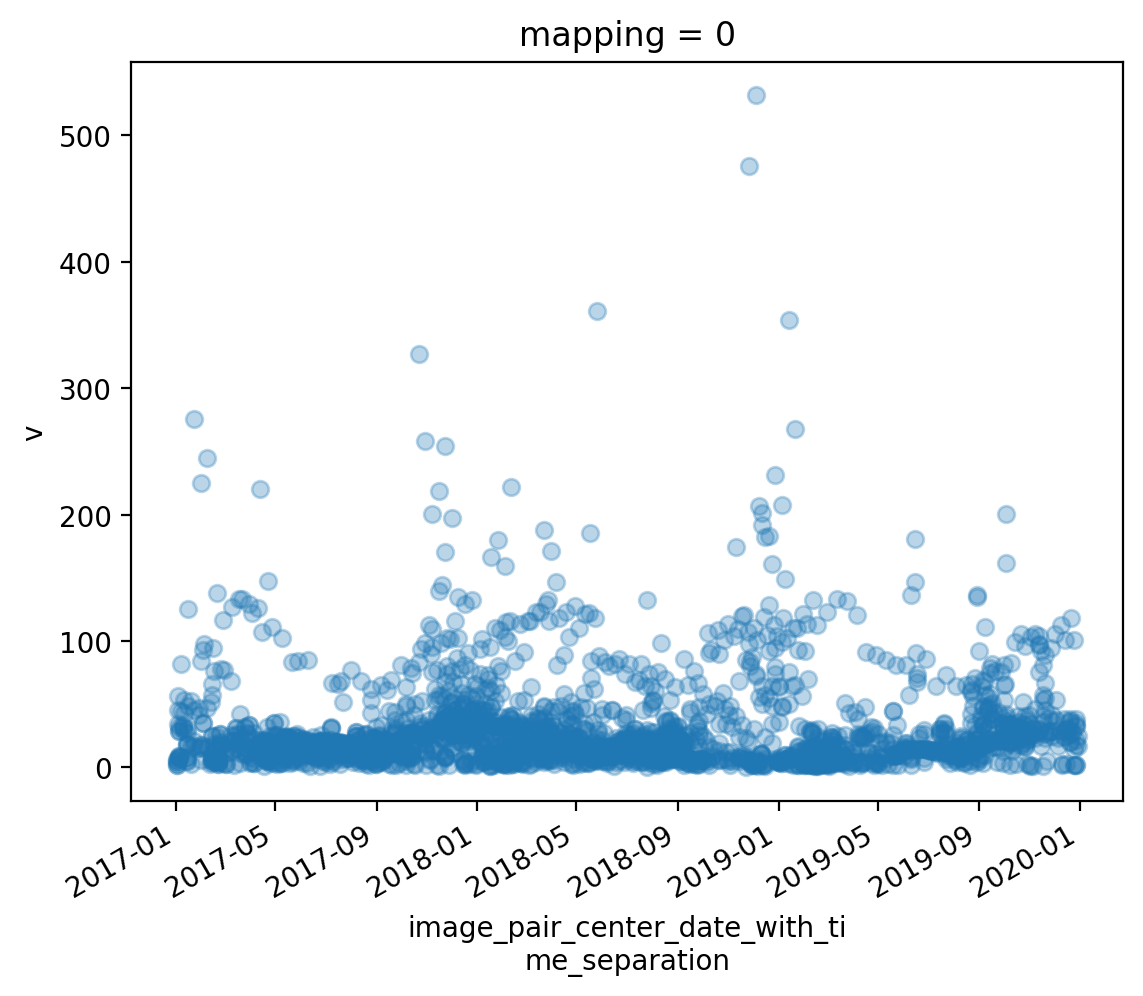

In [4]:
sample_glacier_raster.v.mean(dim=['x','y']).plot(linewidth=0, marker='o', alpha = 0.3);

It looks like there is a large amount of variability in the mean velocity over time. Let's use xarray tools to resample the time dimension.

In [8]:
sample_glacier_raster = sample_glacier_raster.sortby('mid_date')

In [9]:
sample_glacier_raster.mid_date

<xarray.DataArray 'mid_date' (mid_date: 3974)>
array(['2017-01-01T16:15:50.660524032', '2017-01-01T16:15:50.660524032',
       '2017-01-01T16:15:50.660524032', ..., '2019-12-30T04:15:51.190827008',
       '2019-12-30T04:15:54.190602752', '2019-12-30T04:19:46.191115008'],
      dtype='datetime64[ns]')
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2017-01-01T16:15:50.660524032 ... 201...
    mapping   int64 0
Attributes:
    description:    midpoint of image 1 and image 2 acquisition date and time...
    standard_name:  image_pair_center_date_with_time_separation

In [10]:
resample_obj = sample_glacier_raster.resample(mid_date = '1M')
resample_obj

DatasetResample, grouped over '__resample_dim__'
36 groups with labels 2017-01-31, ..., 2019-12-31.

`.resample()` is another grouping operation and returns an object of type `xarray.core.resample.DatasetResample`

In [11]:
sample_glacier_resample_1mo = resample_obj.mean(dim='mid_date')


The below plot is the initial velocity time series in blue, and the velocity data resampled to 1 month intervals in orange

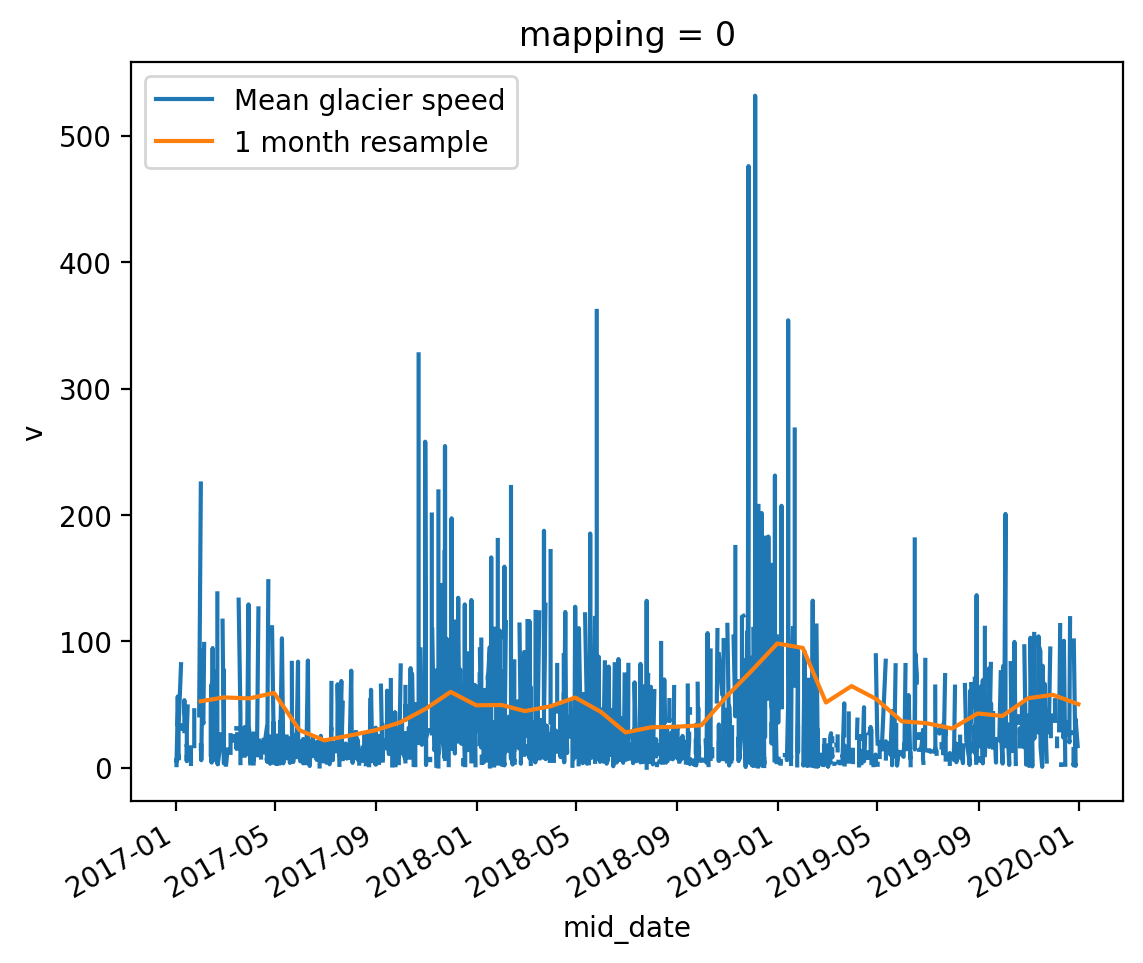

In [14]:
sample_glacier_raster.v.mean(dim=['x','y']).plot(label = 'Mean glacier speed')
sample_glacier_resample_1mo.v.mean(dim=['x','y']).plot(label = '1 month resample')
plt.legend();

This is interesting! Despite what looks to be a pretty noisy signal looking at the full time series, we can start to pick out a seasonal signal and sub-annual velocity variability looking at the velocity data resampled into 1-month bins.

### We could also calculate velocity anomalies... 

To do this, we will use xarray `.groupby()` and `.map()` 


following example from xarray tutorial

We first define a function that subtracts the long-term mean from a single observation. 

In [15]:
def remove_time_mean(x):
    return x-x.mean(dim='mid_date')

We then group the dataset by month and apply the function to calculate the anomaly on each group

In [16]:
sample_glacier_anom = sample_glacier_raster.groupby('mid_date.month').map(remove_time_mean)
sample_glacier_anom

<xarray.Dataset>
Dimensions:                     (mid_date: 3974, x: 73, y: 64)
Coordinates:
  * mid_date                    (mid_date) datetime64[ns] 2017-01-01T16:15:50...
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
Data variables: (12/49)
    M11                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    M12                         (mid_date, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (mid_date) float32 nan nan nan ... nan nan nan
    chip_size_height            (mid_date, y, x) float32 nan nan nan ... nan nan
    chip_size_width             (mid_date, y, x) float32 nan nan nan ... nan nan
    ...                          ...
    vy_error_slow               (mid_date) float32 -13.14 -12.94 ... -11.33
    vy_error_stationary         (mid_date) float32 -13.14 -12.94 ... -11.44
    vy_stable_shift             (mid_date) float32 -9.582 -14.88 ... -15.58
    vy_stable_shift_slow        (mid_date) float32 -9.593 -14.79 ... -15.57
    vy_stable_shift_stationary  (mid_date) float32 -9.582 -14.88 ... -15.58
    cov                         (mid_date) float64 -0.1714 -0.163 ... 0.286

Let's observe the velocity anomaly alongside the velocity time series. 

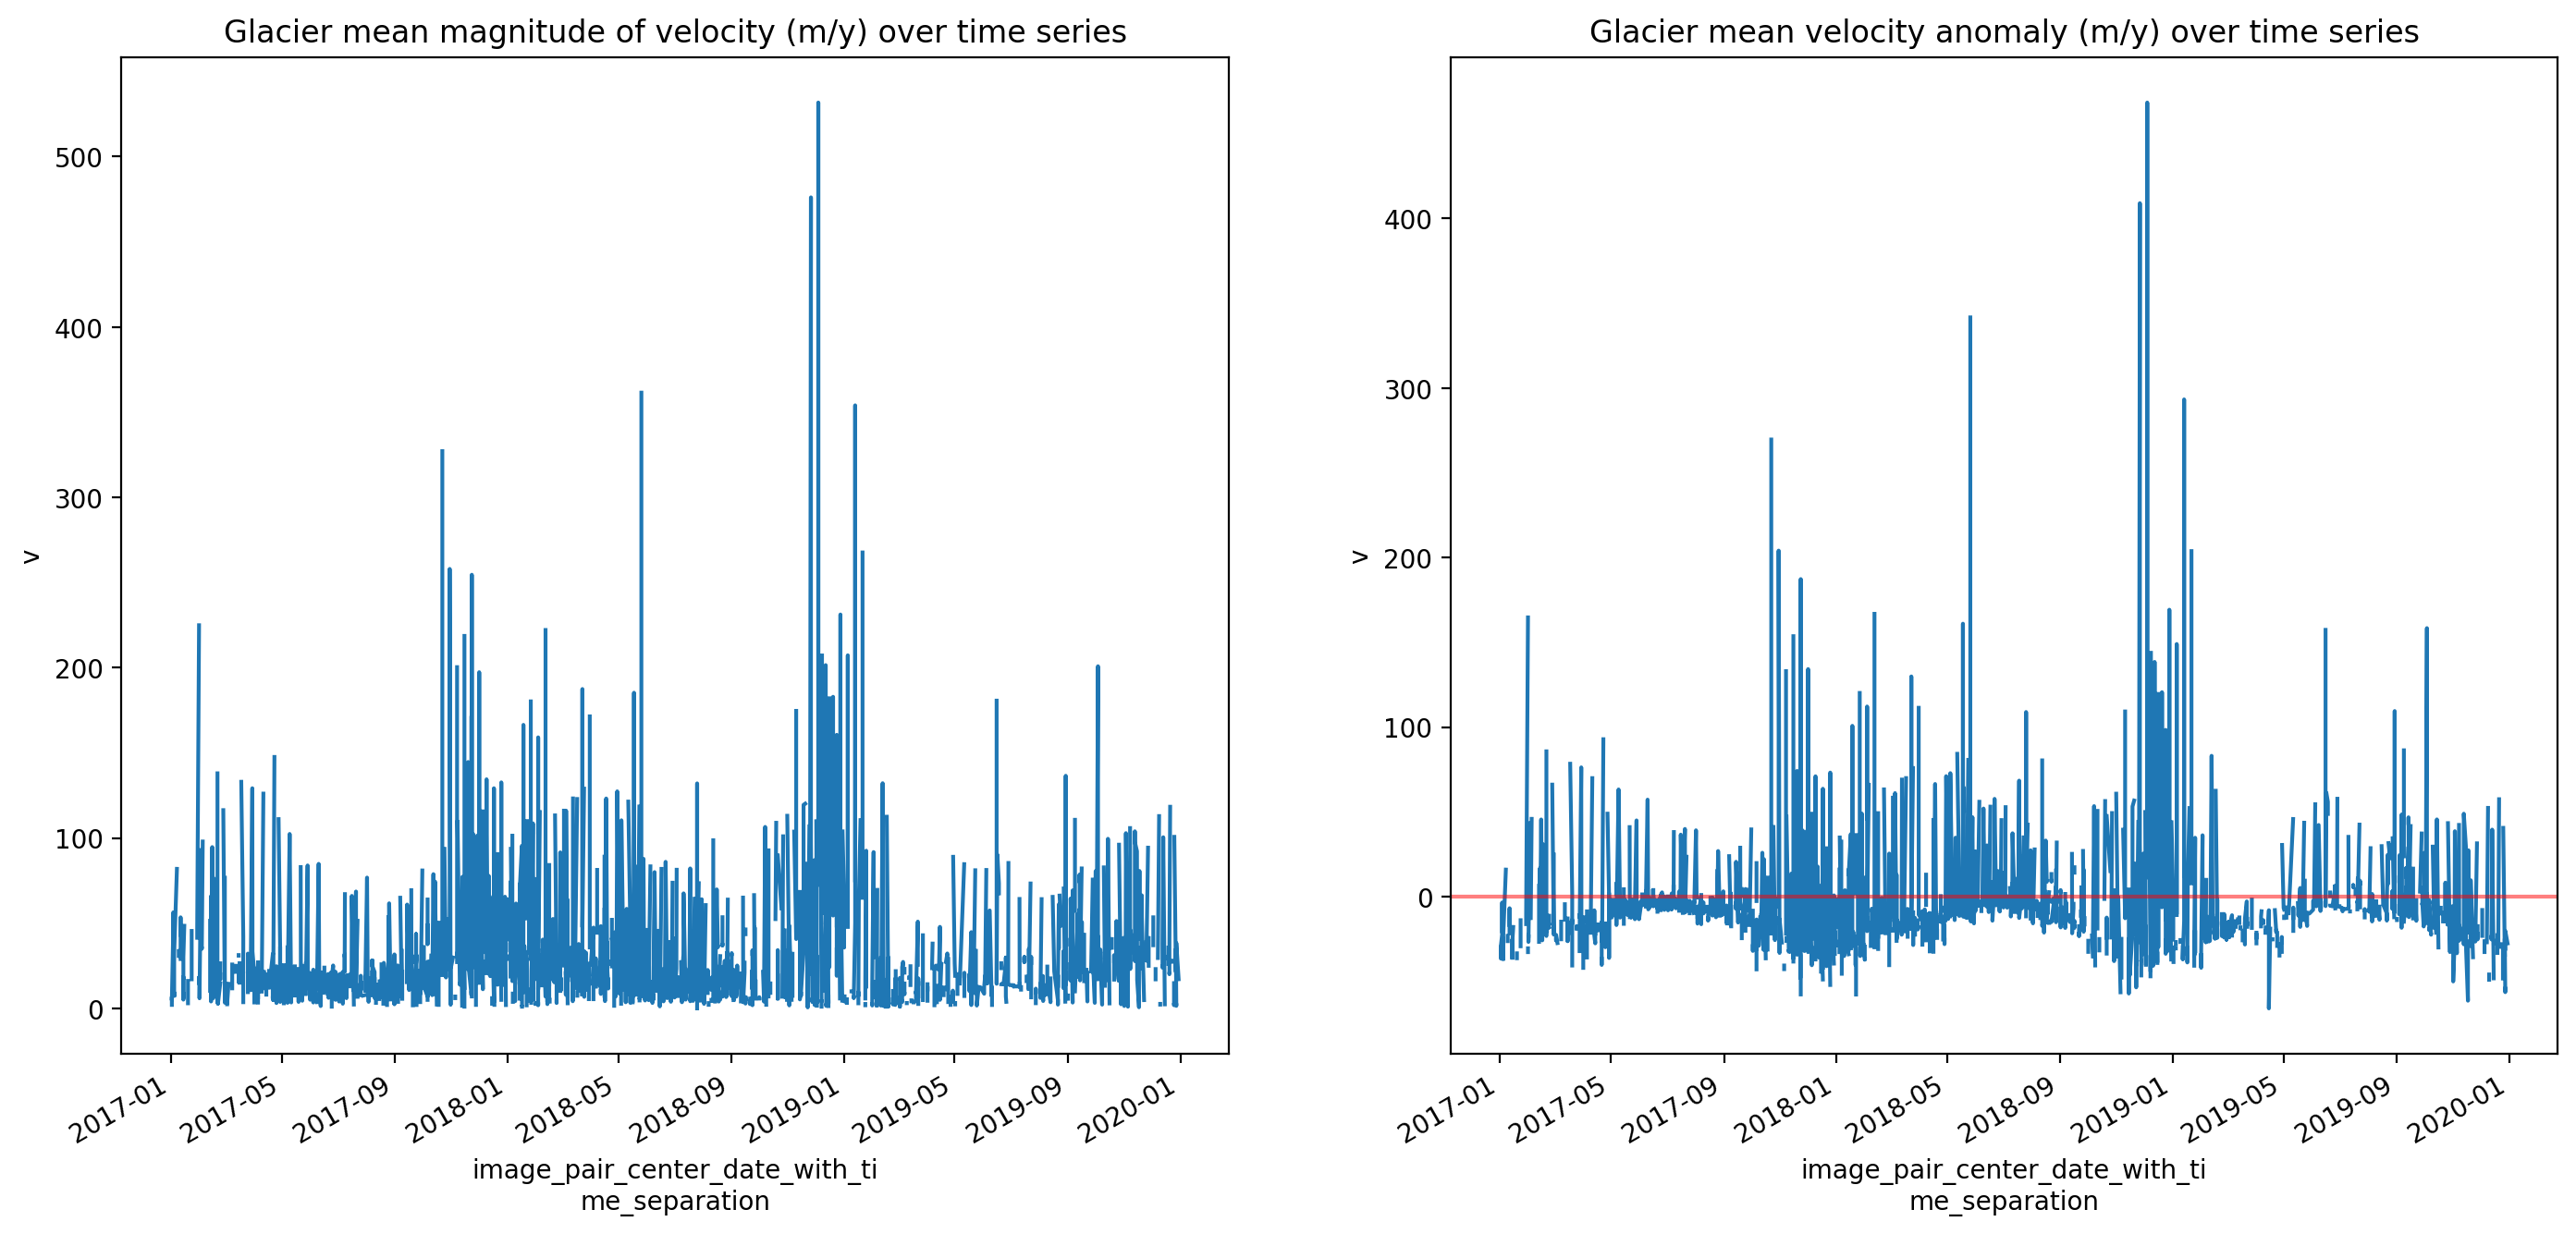

In [17]:
fig, axs = plt.subplots(ncols = 2, figsize=(17,7))
sample_glacier_anom.v.mean(dim=['x','y']).plot(ax=axs[1])
sample_glacier_raster.v.mean(dim=['x','y']).plot(ax=axs[0])
axs[1].axhline(y=0, c = 'red', alpha = 0.5)
axs[0].set_title('Glacier mean magnitude of velocity (m/y) over time series')
axs[1].set_title('Glacier mean velocity anomaly (m/y) over time series');

In the above plot we were taking the mean over the x and y dimensions. Let's take the mean along the mid_date dimension:

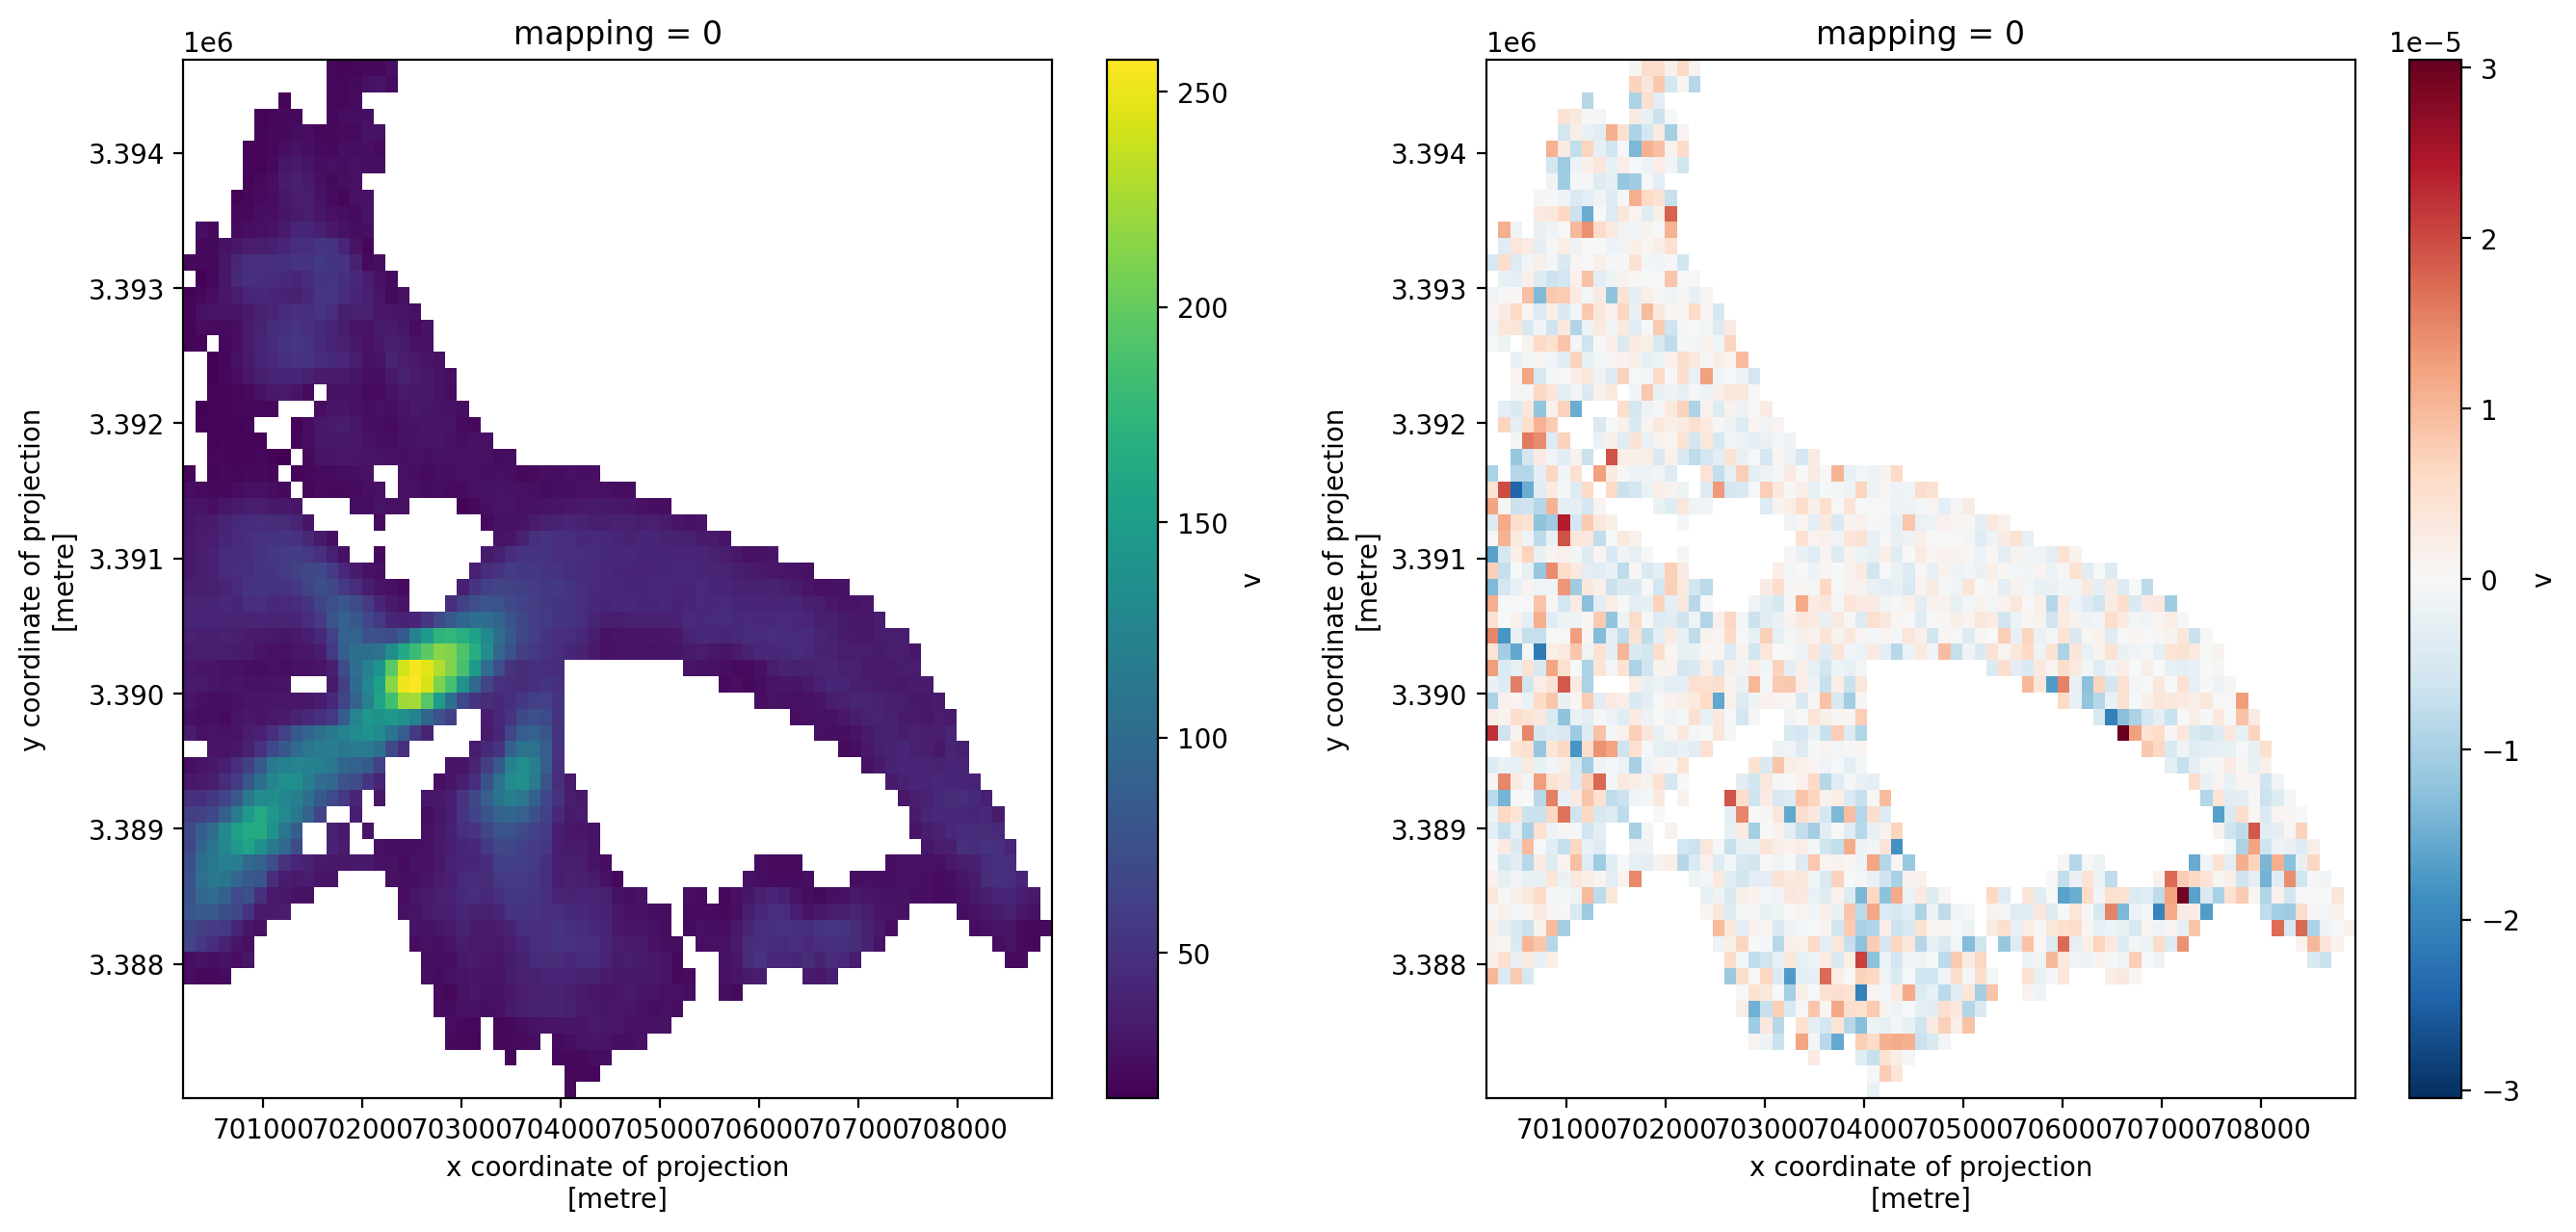

In [18]:
fig, axs = plt.subplots(ncols =2 , figsize=(16,7))
sample_glacier_raster.mean(dim='mid_date').v.plot(ax = axs[0])
sample_glacier_anom.mean(dim='mid_date').v.plot(ax=axs[1]);

## Grouped analysis by season
We have a dense time series of surface velocity data for a single glacier. We can use xarray's `.groupby()` to examine velocity variability further. We will start with using `.groupby()` to break the velocity time series into seasonal means.

In [19]:
seasons_gb = sample_glacier_raster.groupby(sample_glacier_raster.mid_date.dt.season).mean()
#add attrs to gb object
seasons_gb.attrs = sample_glacier_raster.attrs 
seasons_gb

<xarray.Dataset>
Dimensions:                     (season: 4, y: 64, x: 73)
Coordinates:
  * x                           (x) float64 7.003e+05 7.004e+05 ... 7.089e+05
  * y                           (y) float64 3.395e+06 3.395e+06 ... 3.387e+06
    mapping                     int64 0
  * season                      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/49)
    M11                         (season, y, x) float32 nan nan nan ... nan nan
    M11_dr_to_vr_factor         (season) float32 nan nan nan nan
    M12                         (season, y, x) float32 nan nan nan ... nan nan
    M12_dr_to_vr_factor         (season) float32 nan nan nan nan
    chip_size_height            (season, y, x) float32 nan nan nan ... nan nan
    chip_size_width             (season, y, x) float32 nan nan nan ... nan nan
    ...                          ...
    vy_error_slow               (season) float32 17.09 9.745 12.29 20.32
    vy_error_stationary         (season) float32 17.1 9.746 12.29 20.32
    vy_stable_shift             (season) float32 3.759 -4.472 0.4827 3.443
    vy_stable_shift_slow        (season) float32 3.767 -4.477 0.4903 3.428
    vy_stable_shift_stationary  (season) float32 3.759 -4.472 0.4827 3.443
    cov                         (season) float64 0.241 0.2511 0.1558 0.1973
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               25-Sep-2023 22:00:23
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N30E090/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

Breaking down the above cell, we defined how we wanted to group our data (`sample_glacier_raster.mid_date.dt.season`) and the reduction we wanted to apply to each group (`mean()`). After the apply step, xarray automatically combines the groups into a single object. We can see that the `seasons_gb` object is an `xarray.Dataset` with the same dimensions and coordinates as the `sample_glacier_raster` object but that the `seasons_gb` object has a `seasons` dimension as well.

 If you'd like to see another example of this with more detailed explanations, go [here](https://tutorial.xarray.dev/fundamentals/03.2_groupby_with_xarray.html).



To visualize velocity data across the seasonal groups we just defined, we can use xarray's `faceting` functionality. Faceting is a great way to visualize your data in 'small multiples' format. 

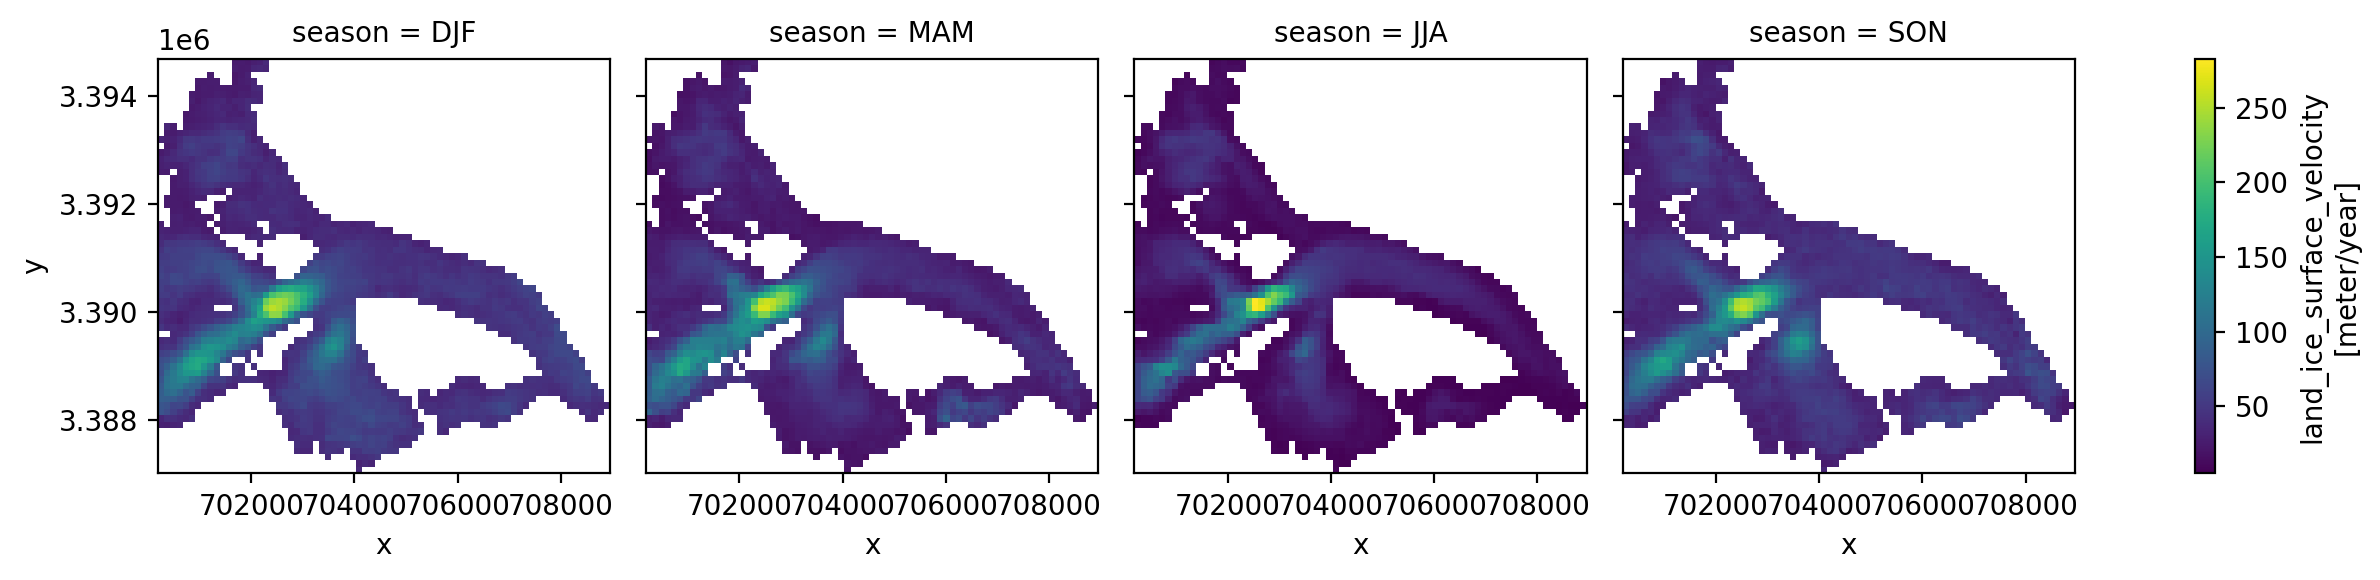

In [20]:
fg = seasons_gb.v.reindex({'season':['DJF','MAM','JJA','SON']}).plot(
    col='season',
);

## Extracting and visualizing data at a single point

We can use xarray's `.sel()` to extract velocity data at a single point or within a subset along given dimensions. In this example, we use `.sel()` to compare the magnitude of velocity of ice flow at a point in the glacier's accumulation zone to the mean magnitude of velocit of the entire glacier. 

In [24]:
#choose coordinates for a point
y = 3.390e6
x = 703000

Text(0.5, 1.0, 'Point speed - mean glacier speed')

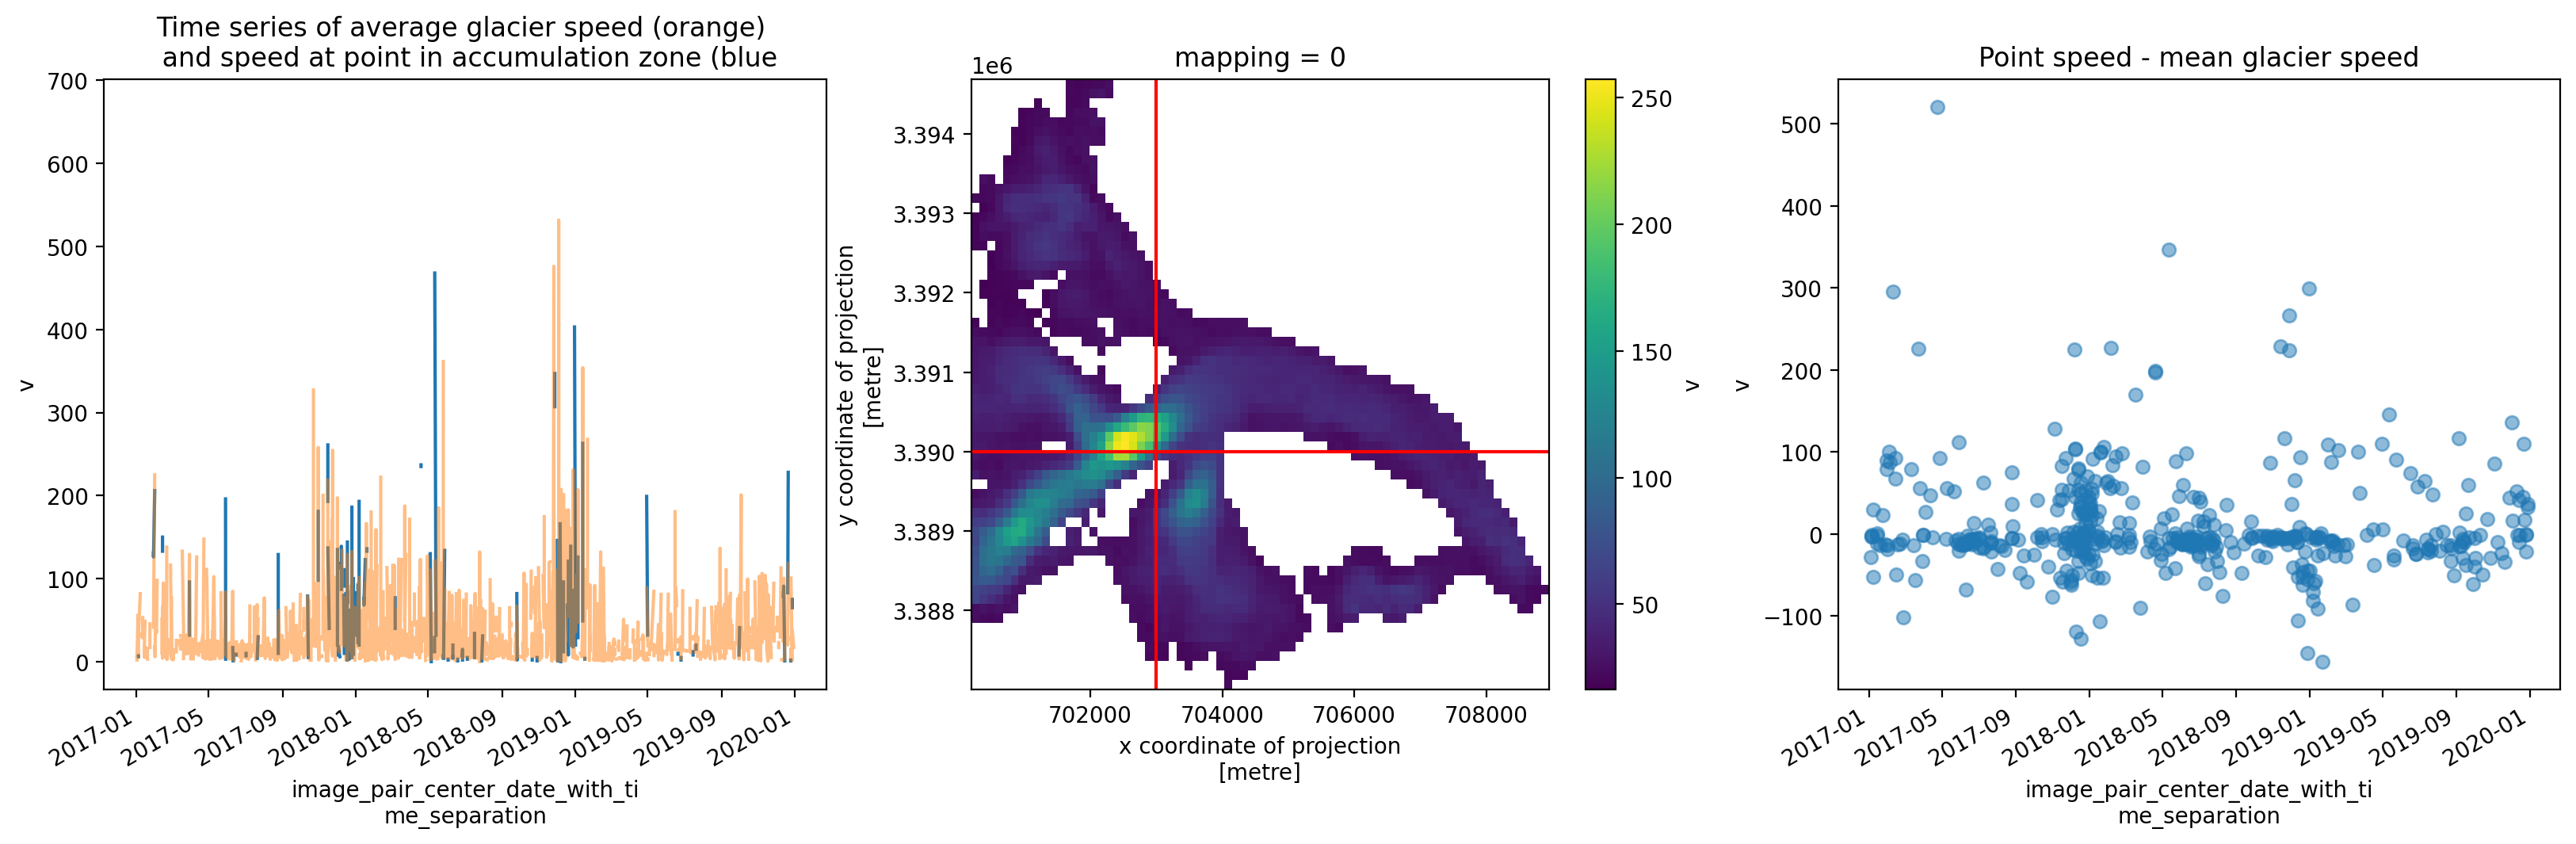

In [25]:
fig, axs = plt.subplots(ncols =3, figsize=(20,5))
sample_glacier_raster.v.sel(x = x, y= y, method='nearest').plot(ax=axs[0]);
sample_glacier_raster.v.mean(dim=['x','y']).plot(ax=axs[0], alpha = 0.5);
sample_glacier_raster.v.mean(dim='mid_date').plot(ax=axs[1]);
axs[1].axvline(x=x, c= 'red')
axs[1].axhline(y=y, c='red')
(sample_glacier_raster.v.sel(x = x, y= y, method='nearest') - sample_glacier_raster.v.mean(dim=['x','y'])).plot(ax=axs[2], linewidth=0, marker='o', alpha = 0.5)
axs[0].set_title('Time series of average glacier speed (orange) \n and speed at point in accumulation zone (blue')
axs[2].set_title('Point speed - mean glacier speed')


### Conclusion

This notebook demonstrated trimming a full ITS_LIVE granule down to the spatial extent of a single glacier outline. We then worked through some basic preliminary data visualization and analysis steps. The next notebook will look at grouped analysis of multiple glaciers.